In [1]:
#importera paket som behövs för koden
from sqlalchemy import create_engine, MetaData, Table, inspect
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
from scipy.stats import ttest_ind

In [2]:
#skapa engine och connection till mssql
engine = create_engine('mssql://ADRIANLAPTOP/AdventureWorks2022?trusted_connection=yes&driver=ODBC+Driver+17+for+SQL+Server')
connection = engine.connect()

# Deskriptiv Sammanfattning

In [3]:
#query för att hämta procent anställda män respektive kvinnor på företaget 
gender = """SELECT Gender,
	COUNT(BusinessEntityID) * 100 / SUM(COUNT(BusinessEntityID)) OVER() AS Percentage
	FROM HumanResources.Employee
	GROUP BY Gender
	;
    """
#Gör till pandas df för att kunna hantera i python
gen_df = pd.read_sql(sql=gender, con=connection)

In [4]:
#query för att hämta och beräkna procent anställda per avdelning
percent = """
WITH emp_cte(Name, NumberOfEmployees) AS
(
SELECT C.Name,
	COUNT(A.BusinessEntityID) AS NumberOfEmployees
FROM HumanResources.Employee AS A
INNER JOIN HumanResources.EmployeeDepartmentHistory AS B
	ON A.BusinessEntityID = B.BusinessEntityID
INNER JOIN HumanResources.Department AS C
	ON B.DepartmentID = C.DepartmentID
GROUP BY B.DepartmentID,  C.Name
)

SELECT A.Name,
	ROUND(CAST(A.NumberOfEmployees AS FLOAT) / B.TotalEmployees, 2) * 100 AS EmployeesPercentage
	FROM emp_cte AS A
CROSS JOIN 
(SELECT COUNT(BusinessEntityID) AS TotalEmployees
	FROM HumanResources.EmployeeDepartmentHistory) AS B
"""
#gör till pandas df
per_df = pd.read_sql(sql=percent, con=connection)

#query för att se totalt anställda
total_emp = """
SELECT COUNT(BusinessEntityID) AS TotalEmployees
    FROM HumanResources.Employee"""
#gör till pandas df och printa
tot_df = pd.read_sql(sql=total_emp, con=connection)
print(tot_df)

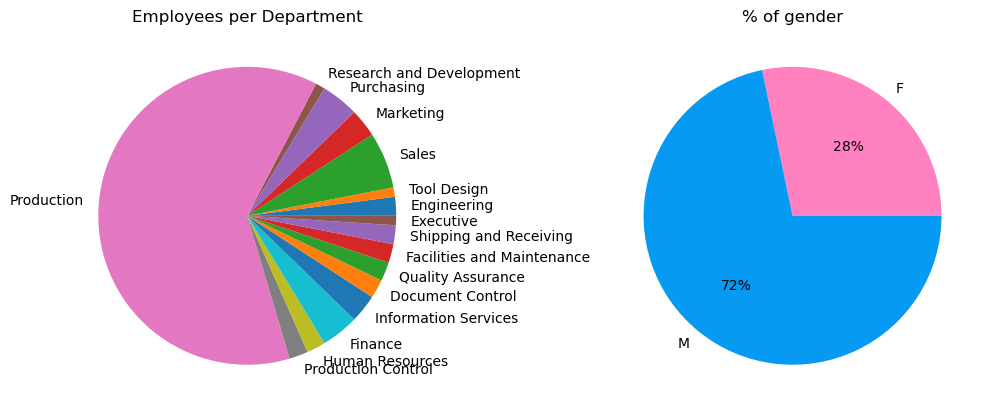

In [6]:
colors = '#FF81C0','#069AF3'
#plotta dataframes
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

#plot 1
axs[0].pie(per_df['EmployeesPercentage'], labels=per_df['Name'])
axs[0].set_title('Employees per Department')

#plot 2
axs[1].pie(gen_df['Percentage'], labels=gen_df['Gender'], colors=colors, autopct='%1.0f%%')
axs[1].set_title('% of gender')
plt.tight_layout()

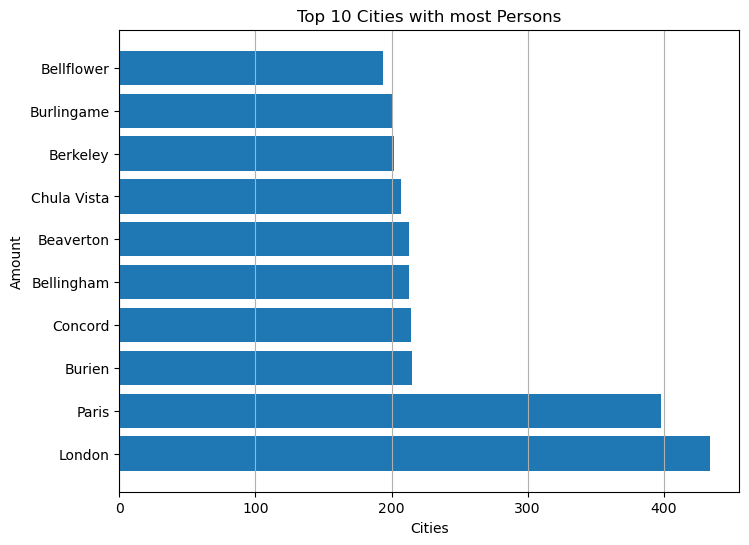

In [7]:
#query för att beräkna antal personer per stad(top 10)
persons = """
SELECT TOP(10) B.City,
	C.Name,
	COUNT(A.BusinessEntityID) AS 'Number of Persons'
	FROM Person.BusinessEntityAddress AS A
INNER JOIN Person.Address  AS B
	ON A.AddressID = B.AddressID
INNER JOIN Person.StateProvince AS C
	ON B.StateProvinceID = C.StateProvinceID
INNER JOIN Person.CountryRegion AS D
	ON	C.CountryRegionCode = D.CountryRegionCode
	GROUP BY B.City, C.Name
ORDER BY COUNT(A.BusinessEntityID) DESC
;
"""
#Gör till pandas df
city_df = pd.read_sql(sql=persons, con=connection)
#plotta datan
fig, ax = plt.subplots(figsize=(8, 6 ))
ax.barh(city_df['City'], city_df['Number of Persons'])
ax.set_title('Top 10 Cities with most Persons')
ax.set_ylabel('Amount')
ax.set_xlabel('Cities')
ax.grid(axis='x')
plt.show()

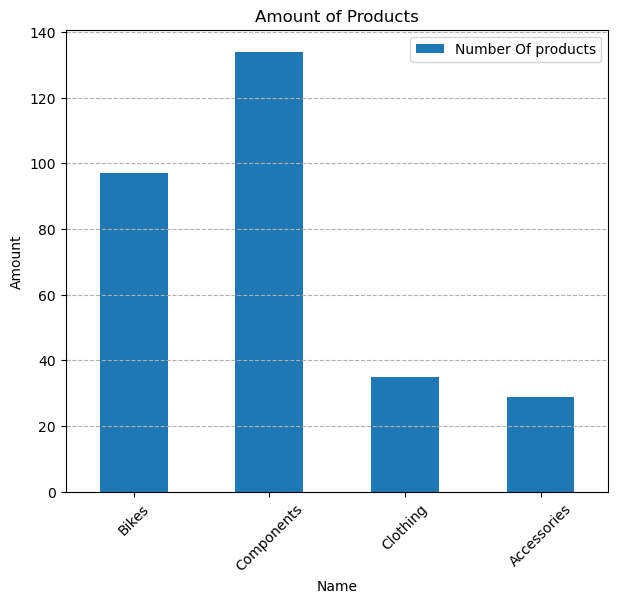

In [8]:
#query för att visa antalet produkter per kategori
products = """
SELECT
	B.Name,
	COUNT(C.ProductID) AS 'Number Of products'
	FROM Production.ProductSubcategory AS A
INNER JOIN Production.ProductCategory AS B
	ON A.ProductCategoryID = B.ProductCategoryID
INNER JOIN Production.Product AS C
	ON C.ProductSubcategoryID = A.ProductSubcategoryID
GROUP BY A.ProductCategoryID, B.Name;
"""
#gör till pandas df
prod_df = pd.read_sql(sql=products, con=connection)
#plotta datan
fig, ax = plt.subplots(figsize=(7, 6))
prod_df.plot(kind='bar', x='Name', y='Number Of products', ax=ax, rot=45)
ax.set_title('Amount of Products')
ax.set_ylabel('Amount')
ax.grid(axis='y' , linestyle='--')

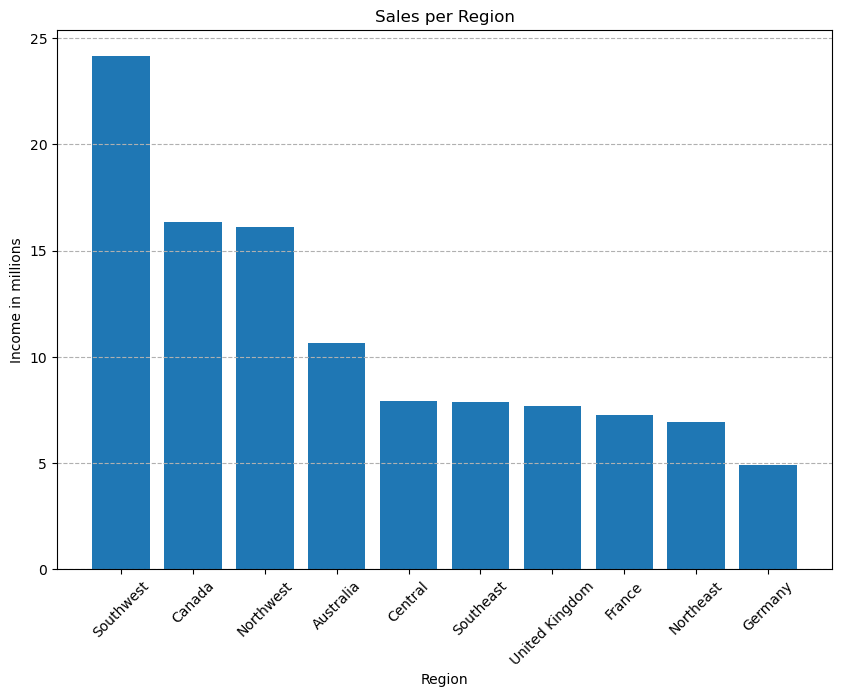

In [9]:
#query för beräkna försäljning per region
sales = """
SELECT A.Name,
	SUM(B.SubTotal) AS 'Amount of income'
	FROM Sales.SalesTerritory AS A
INNER JOIN Sales.SalesOrderHeader AS B
	ON A.TerritoryID = B.TerritoryID
	GROUP BY A.Name
    ORDER BY SUM(B.SubTotal) DESC
;
"""
#gör till pandas df
sales_df = pd.read_sql(sql=sales, con=connection)
#plotta datan
fig, ax = plt.subplots(figsize=(10, 7))
ax.bar(sales_df['Name'], sales_df['Amount of income'])
ax.set_title('Sales per Region')
ax.set_ylabel('Income in millions')
ax.set_xlabel('Region')
ax.set_yticks([0, 5e6, 1e7, 1.5e7, 2e7, 2.5e7])
ax.set_yticklabels(['0', '5', '10', '15', '20', '25'])
plt.xticks(rotation=45)
ax.grid(axis='y', linestyle='--')

Text(0.5, 0, 'Year')

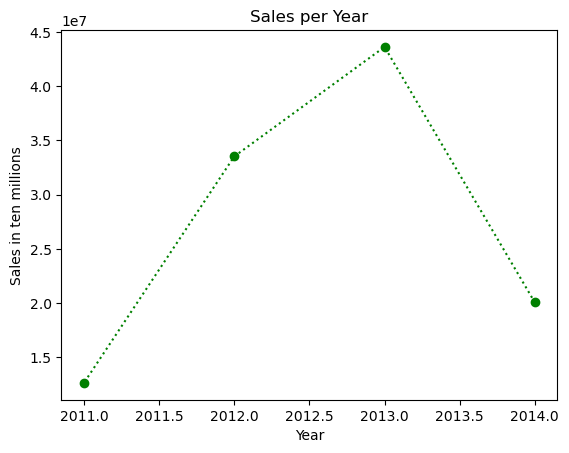

In [10]:
#query för att beräkna försäljning per år för hela databasen
sales_year="""
SELECT YEAR(OrderDate) AS Year,
	SUM(SubTotal) AS TotalSales
FROM Sales.SalesOrderHeader
GROUP BY YEAR(OrderDate) 
ORDER BY YEAR(OrderDate) DESC
;
"""
#gör till pandas df
df1 = pd.read_sql(sql=sales_year, con=connection)
#plotta datan
fig, ax = plt.subplots()
ax.plot(df1['Year'], df1['TotalSales'], color='green', marker='o', linestyle='dotted')
ax.set_title('Sales per Year')
ax.set_ylabel('Sales in ten millions')
ax.set_xlabel('Year')

# Analys av datan

In [11]:
#query som beräknar försäljning per månad för varje år
sales = """
SELECT YEAR(OrderDate) AS Year,
	MONTH(OrderDate) AS Month,
	SUM(SubTotal) AS Sales
FROM Sales.SalesOrderHeader
	WHERE YEAR(OrderDate) BETWEEN 2011 AND 2014
GROUP BY YEAR(OrderDate),
	MONTH(OrderDate)
ORDER BY MAX(OrderDate);
"""
#gör data till pandas df
sales_year_df = pd.read_sql(sql=sales, con=connection)

#visa tabell
sales_year_df

,Year,Month,Sales
0,2011,5,5.038059e+05
1,2011,6,4.589108e+05
2,2011,7,2.044600e+06
3,2011,8,2.495817e+06
4,2011,9,5.020738e+05
5,2011,10,4.588762e+06
6,2011,11,7.378398e+05
7,2011,12,1.309863e+06
8,2012,1,3.970627e+06
9,2012,2,1.475427e+06


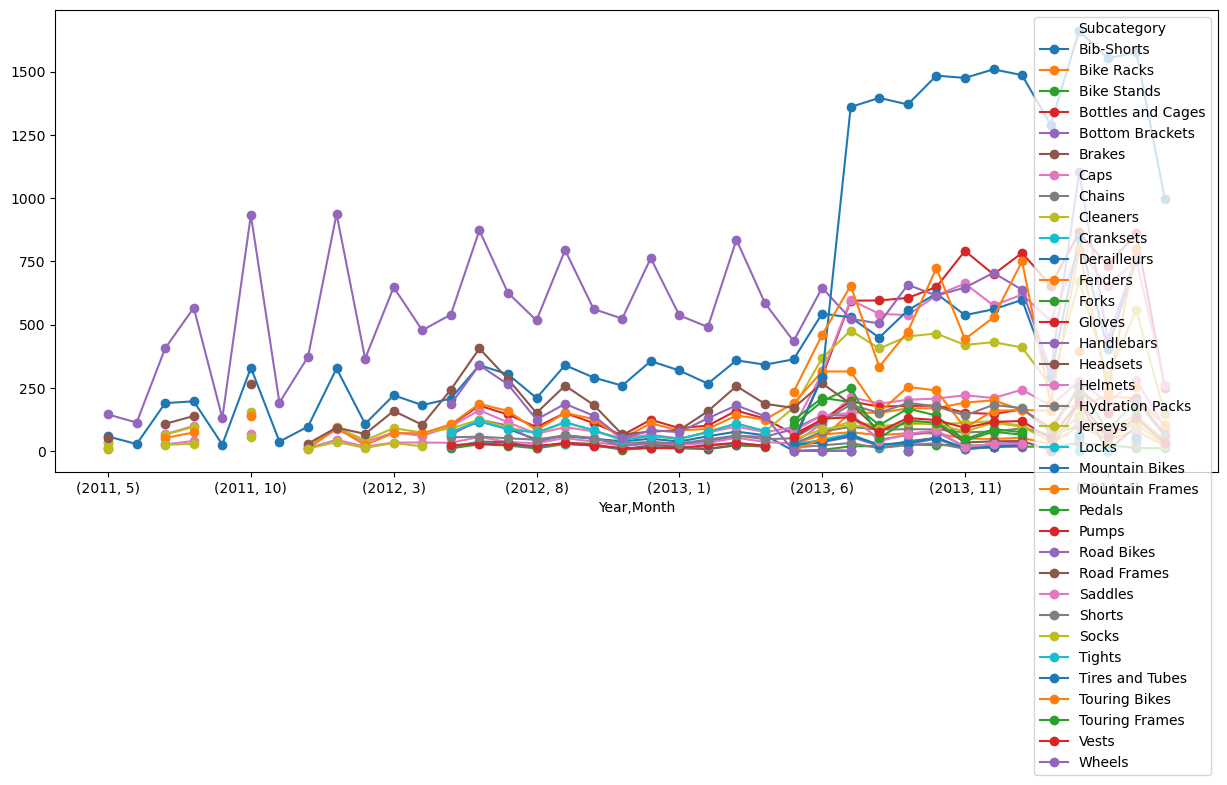

In [12]:
#query som hämtar och beräknar försäljning per subcategorys för varje månad
all_products = """
SELECT D.Name,
	YEAR(A.OrderDate) AS Year,
	MONTH(A.OrderDate) AS Month,
	COUNT(B.ProductID) AS NbrSold
	FROM Sales.SalesOrderHeader AS A
INNER JOIN Sales.SalesOrderDetail AS B
	ON A.SalesOrderID = B.SalesOrderID
INNER JOIN Production.Product AS C
	ON B.ProductID = C.ProductID
INNER JOIN Production.ProductSubcategory AS D
	ON C.ProductSubcategoryID = D.ProductSubcategoryID
GROUP BY D.Name,
	YEAR(A.OrderDate),
	MONTH(OrderDate)
	ORDER BY MAX(OrderDate);
    """
#gör till pandas df
pr_df = pd.read_sql(sql=all_products, con=connection)
#pivot för bättre läsbarhet i graf
df_pivot = pr_df.pivot_table(values='NbrSold', index=['Year', 'Month'], columns='Name')
#plotta
fig, ax = plt.subplots(figsize=(15, 6))
df_pivot.plot(marker='o', ax=ax)
ax.legend(title='Subcategory', loc='upper right')

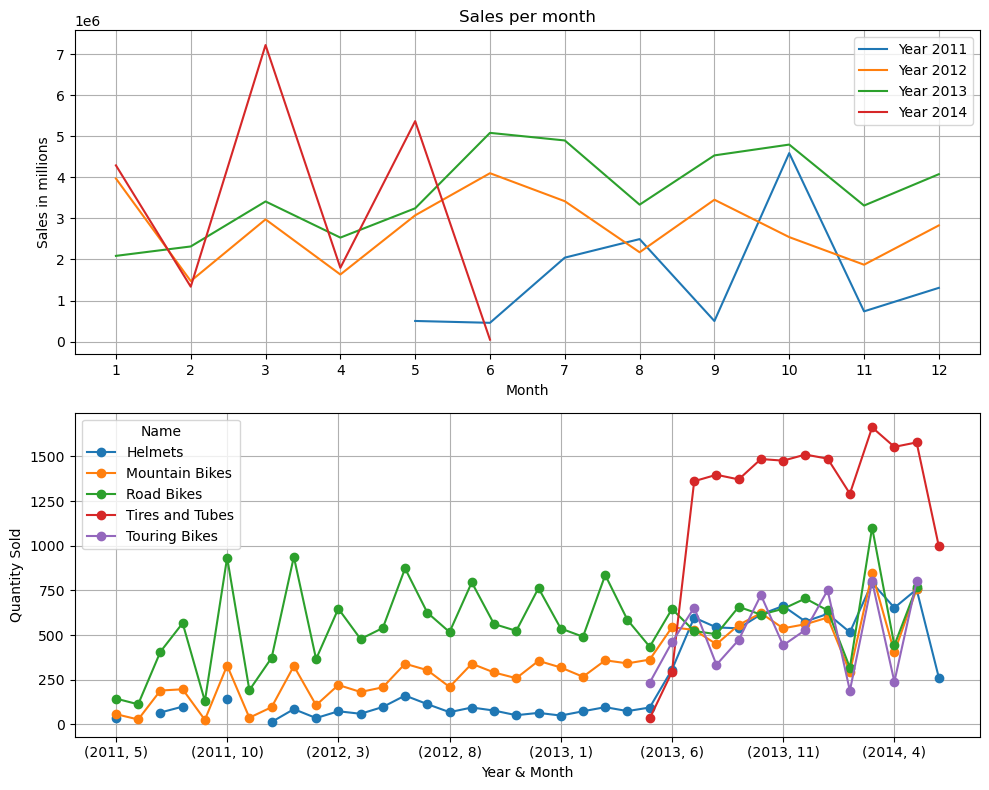

In [13]:
#filtrera ut produkter som jag vill kolla närmare på
some_products = """
SELECT D.Name,
	YEAR(A.OrderDate) AS Year,
	MONTH(A.OrderDate) AS Month,
	COUNT(B.ProductID) AS NbrSold
	FROM Sales.SalesOrderHeader AS A
INNER JOIN Sales.SalesOrderDetail AS B
	ON A.SalesOrderID = B.SalesOrderID
INNER JOIN Production.Product AS C
	ON B.ProductID = C.ProductID
INNER JOIN Production.ProductSubcategory AS D
	ON C.ProductSubcategoryID = D.ProductSubcategoryID
	WHERE D.Name IN ('Road Bikes', 'Mountain Bikes', 'Tires and Tubes', 'Touring Bikes', 'Helmets')
GROUP BY D.Name,
	YEAR(A.OrderDate),
	MONTH(OrderDate)
	ORDER BY MAX(OrderDate);
"""
some_prod_df = pd.read_sql(sql=some_products, con=connection)
#pivot
some_prod_df_pivot = some_prod_df.pivot_table(values='NbrSold', index=['Year', 'Month'], columns='Name')

#plotta datan
fig, axs = plt.subplots(2, 1, figsize=(10,8))
#plot 1
for year in sales_year_df['Year'].unique():
    year_data = sales_year_df[sales_year_df['Year'] == year]
    axs[0].plot(year_data['Month'], year_data['Sales'], label=f'Year {year}')
axs[0].set_xticks([1, 2, 3 ,4 ,5, 6, 7, 8, 9, 10, 11, 12])
axs[0].set_ylabel('Sales in millions')
axs[0].set_xlabel('Month')
axs[0].set_title('Sales per month')
axs[0].legend()
axs[0].grid(True)

#plot 2 
some_prod_df_pivot.plot(ax = axs[1], marker='o')
axs[1].set_ylabel('Quantity Sold')
axs[1].set_xlabel('Year & Month')
axs[1].grid(True)
plt.tight_layout()

In [14]:
#query som hämtar alla kampanjer(mindre än 6 månader)
offers = """
SELECT DISTINCT A.SpecialOfferID,
	A.StartDate,
	A.EndDate,
	A.Description
	FROM Sales.SpecialOffer AS A
INNER JOIN Sales.SpecialOfferProduct AS B
	ON A.SpecialOfferID = B.SpecialOfferID
INNER JOIN Production.Product AS C
	ON B.ProductID = C.ProductID 
	WHERE A.DiscountPct > 0
	AND DATEDIFF(MONTH, A.StartDate, A.EndDate) <=6
;
"""
#gör till pandas df
offers_df = pd.read_sql(sql=offers, con=connection)

offers_df

,SpecialOfferID,StartDate,EndDate,Description
0,7,2012-04-13,2012-05-29,Mountain-100 Clearance Sale
1,8,2012-05-30,2012-06-29,Sport Helmet Discount-2002
2,9,2012-05-30,2012-07-30,Road-650 Overstock
3,10,2013-05-14,2013-07-29,Mountain Tire Sale
4,11,2013-05-30,2013-06-29,Sport Helmet Discount-2003
5,12,2013-05-30,2013-07-14,LL Road Frame Sale
6,13,2013-05-30,2013-08-29,Touring-3000 Promotion
7,14,2013-05-30,2013-08-29,Touring-1000 Promotion
8,15,2013-07-14,2013-08-14,Half-Price Pedal Sale
9,16,2014-03-31,2014-05-30,Mountain-500 Silver Clearance Sale


In [15]:
#query som räknar ut försäljning per dag
sales_day = """
SELECT OrderDate,
	SUM(SubTotal) AS Sales
FROM Sales.SalesOrderHeader
GROUP BY OrderDate
ORDER BY OrderDate
;"""
#gör till pandas df
df3 = pd.read_sql(sql=sales_day, con=connection)
print(df3)

      OrderDate        Sales
0    2011-05-31  503805.9169
1    2011-06-01   13931.5200
2    2011-06-02   15012.1782
3    2011-06-03    7156.5400
4    2011-06-04   15012.1782
...         ...          ...
1119 2014-06-26    1502.8500
1120 2014-06-27    1747.6700
1121 2014-06-28    1847.4600
1122 2014-06-29    1477.6100
1123 2014-06-30    2643.6100

[1124 rows x 2 columns]


In [16]:
#beräkningar för att få lite känsla för data.
#medelvärde och median för försäljning för dag
print("Medelvärde för försäljning under en dag:", df3['Sales'].mean().round())
print("Median för försäljning under en dag:", df3['Sales'].median())
print("\n")
#Medelvärde och median för försljning för dag under kampanj 7
offer_7= df3[(df3['OrderDate'] >= '2012-04-13') & (df3['OrderDate'] <= '2012-05-29')]
print("Medelvärde för försäljning per dag under kampanj 7:", offer_7['Sales'].mean().round())
print("Median för försäljning per dag under kampanj 7:", offer_7['Sales'].median())

Medelvärde för försäljning under en dag: 97728.0
Median för försäljning under en dag: 21559.11895


Medelvärde för försäljning per dag under kampanj 7: 43151.0
Median för försäljning per dag under kampanj 7: 21787.1582


In [17]:
#tider för kampanjer
start_date2012 = '2012-04-13'
end_date2012 = '2012-07-30'
start_date2013 = '2013-05-14'
end_date2013 = '2013-08-29'
start_date2014 = '2014-03-31'
end_date2014 = '2014-05-30'

#skapa stickprov för försäljning under kampanjer
sale_data = df3[
    ((df3['OrderDate'] >= start_date2012) & (df3['OrderDate'] <= end_date2012)) |
    ((df3['OrderDate'] >= start_date2013) & (df3['OrderDate'] <= end_date2013)) |
    ((df3['OrderDate'] >= start_date2014) & (df3['OrderDate'] <= end_date2014)) ]
#stickprov för resterande försäljningar, alltså sålda utan kampanj
non_sale_data =df3[~df3['OrderDate'].isin(sale_data['OrderDate'])]

In [18]:
#hypotesprövning 
t_stat, p_value = ttest_ind(sale_data['Sales'], non_sale_data['Sales'])
print('T-värde:', t_stat)
print('P-värde:', p_value)

T-värde: 1.0345205679602718
P-värde: 0.30111578621728435


In [19]:
#stickprov för försäljningar under specifikt kampanj 7
sale_7= df3[(df3['OrderDate'] >= '2012-04-13') & (df3['OrderDate'] <= '2012-05-29')]
#stickprov för resterande försäljningar
rest_data = df3[~df3['OrderDate'].isin(sale_7['OrderDate'])]

In [20]:
#hypotesprövning för kampanj 7
t_stat, p_value = ttest_ind(sale_7['Sales'], rest_data['Sales'])
print('T-värde:', t_stat)
print('P-värde:', p_value)

T-värde: -0.889672939878439
P-värde: 0.37383223839998936
